# Compare Arima results from Skforecast, pmdarima and statsforecast

In [27]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.datasets import sunspots, co2, macrodata, nile
from pmdarima import ARIMA as pmdarima_ARIMA
from skforecast.stats import Arima as skf_Arima
from statsforecast.models import ARIMA as statsforecast_Arima
from skforecast.datasets import fetch_dataset
import warnings
import timeit

In [80]:
# Data sets
# ==============================================================================

datasets = {}

air_passengers = pd.Series(np.array([
    112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,
    115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
    145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
    171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
    196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
    204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
    242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
    284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
    315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
    340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
    360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
    417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432], dtype=np.float64),
    name="air_passengers"
)
datasets['air_passengers'] = {'data': air_passengers, 'seasonal_periods': 12, 'order': (0, 1, 1), 'seasonal_order': (0, 1, 1), 'steps_ahead': 24}

monthly_data = pd.Series(np.array([
    156.83145573290403, 198.01090980146668, 207.9294519090584, 192.50881106335353, 143.88220402427257, 
    109.61247461878796, 51.02783684004386, 28.830574625122402, 33.3467665506287, 23.522525664450917, 48.66533667747763,
    107.43274507456638, 165.64013486015855, 200.15344049878215, 211.5155166091762, 202.1730030845587, 149.413779424248, 
    114.8274687399386, 60.3144164424087, 29.459673433893094, 5.0319329715038, 25.255954513588897, 69.46784873284764,
    118.75490591398581, 138.50191829826542, 215.75333240194234, 220.07545455740012, 217.15814111236023, 191.90129990488526,
    108.8088676939804, 54.29519820628114, 37.54688841628041, -1.2454449934178413, 34.66284406168156, 48.04912269201285,
    107.40050982214626]),
    name='monthly_data')
datasets['monthly_data'] = {'data': monthly_data, 'seasonal_periods': 12, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 24}

quarterly_data = pd.Series(np.array([
    255.5207840618145, 87.99560565039364, -50.22197639689352, 100.31688949671437, 242.67651141877238, 100.52525241597803,
    -46.08957390612448, 95.35610392578661, 261.43281111884124, 105.959923879395, -52.332682335543794, 110.88162945765853, 257.26397049987094, 
     101.13289060185168, -62.98234513672319, 87.3748290530375, 263.8323849444473, 108.91573342476657, -61.783202628041785, 110.22246835230273, 
     245.01319786445208, 110.9737910820319, -53.64130850287849, 113.70236140280312]),
    name='quarterly_data'
)
datasets['quarterly_data'] = {'data': quarterly_data, 'seasonal_periods': 4, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 8}

daily_data = pd.Series(np.array([
    1749.349184518034, 2012.0710580391506, 1493.0154891668535, 462.047082761232, 50.865783828344284, 460.06967664987263, 1046.5098920989092, 
    1732.6813259649934, 2044.4650005528904, 1457.6653933204234, 656.3330212062435, 53.85076527512874, 302.9618975758385, 1000.6310493662936, 
    1806.1705543691553, 2074.918150381484, 1471.6715561040307, 681.5663548831715, 55.187666687122146, 117.84251942586233, 1030.210501819249, 
    1760.1321040466987, 2097.794745263811, 1580.353318797828, 490.2946924710491, -133.83617211844629, 321.1748761486958, 1026.0687262646018, 
    1831.4742310147008, 2111.9472142549675, 1301.6816855005184, 636.8966872740124, 67.57821840581548, -4.331952059498036, 974.7489363552428, 
    1624.1873281795063]),
    name='daily_data'
)
datasets['daily_data'] = {'data': daily_data, 'seasonal_periods': 7, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 14}

hourly_data = pd.Series(np.array([
    71.37918135156875, 85.8543432348506, 79.3066299785248, 88.19294702225602, 74.52408618413598, 84.38330781641443, 115.56079010814668, 102.40505779052614, 
    87.25420321325205, 80.38382892783665, 72.13377425796332, 46.731426724867745, 30.549222541945262, 22.478309134678916, 5.298309941546334, 6.5835758431834215, -14.532761281188694,
    -13.752146188889045, 11.654961659112109, 23.679607106346317, 26.956866249535913, 52.26239608957695, 50.80004597793651, 60.94287490127781, 48.83010084842864, 86.68838987000643, 
    84.05495480060645, 86.06584416580166, 111.4879720574784, 92.44965808952739, 103.6212930503394, 96.27502856687921, 86.05268297846618, 62.85164253224801, 72.0989871692978, 
    52.06960406236867, 33.237540663475635, 22.915531503795766, 25.096479486631594, 24.577070770996464, 4.03716379051701, 16.729657793875337, 17.008242179578367, 32.82357605387345, 
    17.97418533364006, 39.860438966124455, 36.07701429609706, 41.82545719386261, 62.462055622253864, 97.20672004658493, 83.0182777674507, 99.23832608858793, 121.29165042874155, 
    104.19097850654907, 104.61251220128679, 104.72392728847008, 94.74827365170356, 94.24573313491871, 66.77858338924341, 42.585482039769644, 37.32753690990771, 51.671441510808414, 
    18.20823249084842, 26.42778376467034, 3.0398876707858973, 19.466122730029763, 19.123398367257554, 16.125321333077846, 15.29886562062449, 25.74054170566481, 36.27166701289651,
    57.844144408882755, 81.95238665680269, 89.0832254833273, 100.38285256092303, 108.50090948549702, 116.68981514762598, 107.71994371650905, 101.54405738576708, 93.53370125543341,
    90.96766772636944, 99.17768408897605, 72.12136512544116, 61.731781256486386, 44.29800236372274, 44.29479716079315, 19.94448750712072, 28.79830754108969, 1.0201183482837113,
    3.219090053820035, 14.044953721984703, 14.622909376186058, 24.259667824694663, 13.590057683840271, 51.36043164778454, 57.392081392764894]),
    name='hourly_data'
)
datasets['hourly_data'] = {'data': hourly_data, 'seasonal_periods': 24, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 40}

no_seasonal_data = pd.Series(np.array([
    97.6050489407213, 115.66030359421944, 109.55208728844406, 91.65541470371792, 85.24607237085254, 89.6443661655059, 97.01577728014611, 
    104.33860351448578, 104.28238560313135, 111.58948171956203, 99.80718547190561, 97.25530601257535, 92.42851598447066, 114.78920397777841, 
    103.4567675295882, 114.39737849488006, 103.95460179432608, 106.86776724365077, 100.50976902283695, 100.3304086154929, 110.96348348012472, 
    112.00890359198776, 103.64812953321086, 90.26853823578205]),
    name='no_seasonal_data'
)
datasets['no_seasonal_data'] = {'data': no_seasonal_data, 'seasonal_periods': 1, 'order': (2, 1, 2), 'seasonal_order': (0, 0, 0), 'steps_ahead': 10}

strong_seasonal = pd.Series(np.array([
    202.7, 270.1, 313.1, 273.5, 209.7, 112.3, 5.0, -75.0, -109.4, -75.3, -16.6, 100.1, 201.6, 266.2, 297.9, 270.6, 200.0, 90.4, 
    -8.1, -64.5, -85.8, -74.8, 5.4, 88.5, 192.7, 264.3, 285.3, 284.2, 195.7, 98.9, 5.0, -55.7, -99.7, -66.1, 1.4, 99.3, 195.8, 270.7, 290.8, 277.1, 
    205.7, 103.1, 1.3, -77.3, -95.2, -84.1, -14.2, 98.5, 209.4, 276.4, 296.1, 267.0, 205.8, 103.6, 11.4, -69.5, -94.4, -76.1, 11.3, 99.9, 201.6, 
    258.8, 299.5, 279.8, 191.2, 76.2, 4.1, -65.9, -99.7, -89.8, 12.6, 82.8, 203.7, 289.3, 299.4, 284.6, 190.8, 98.1, 13.9, -67.1, -117.6, -66.4, 
    1.3, 94.8, 226.8, 273.9, 319.0, 280.4, 199.6, 113.5, 4.6, -62.3, -102.2, -69.4, 0.2, 105.3, 215.0, 264.6, 277.7, 262.5, 182.3, 112.6, -1.8, -71.6,
    -90.0, -80.8, -6.0, 107.9, 209.8, 262.3, 301.1, 273.4, 189.8, 96.6, 1.8, -78.5, -101.8, -52.8, -4.6, 100.1, 209.7, 278.7, 308.4, 268.1, 195.3, 
    114.5, -12.0, -73.4, -117.9, -76.1, 6.3, 103.6, 215.9, 262.3, 280.3, 271.4, 221.6, 104.7, -20.0, -81.7, -86.0, -70.8, -9.8, 94.4, 205.7, 283.2, 
    287.0, 244.5, 198.5, 89.3, 2.1, -68.8, -92.9, -51.9, 1.7, 97.8, 185.7, 270.3, 292.2, 263.7, 216.4, 102.4, 7.4, -79.3, -104.0, -71.8, 4.2, 97.5,
    212.6, 268.3, 304.9, 253.5, 201.0, 114.5, 5.3, -90.1, -108.7, -81.5, 0.6, 90.7, 196.2, 284.9, 288.6, 291.5, 200.8, 104.5, -1.8, -69.9, -99.4, 
    -80.4, -10.1, 104.0, 185.9, 286.6, 292.4, 275.0, 205.9, 100.4, -6.6, -84.7]),
    name='strong_seasonal'
)
datasets['strong_seasonal'] = {'data': strong_seasonal, 'seasonal_periods': 12, 'order': (0, 1, 1), 'seasonal_order': (0, 1, 1), 'steps_ahead': 24}

# Multiple seasonal periods (simulate daily data with both weekly and annual patterns)
multi_seasonal = pd.Series(np.array([
    102.9, 101.1, 100.4, 91.5, 77.2, 104.5, 108.2, 101.4, 105.0, 105.7, 84.5, 112.6, 83.9, 86.0, 96.9, 105.7, 113.5, 102.2, 95.5, 
    96.1, 102.6, 107.2, 95.8, 103.8, 88.1, 124.5, 101.6, 120.7, 117.4, 124.3, 127.8, 110.9, 96.8, 116.7, 121.6, 99.4, 113.9, 93.8, 99.5, 93.9, 136.5, 
    89.9, 115.2, 106.7, 109.5, 98.6, 107.3, 98.2, 98.7, 106.6, 118.0, 110.1, 109.8, 126.1, 97.4, 107.0, 90.6, 122.1, 118.4, 92.6, 102.7, 123.0, 103.4,
    104.1, 119.2, 94.3, 115.0, 106.1, 110.9, 118.9, 108.5, 108.8, 111.1, 117.0, 94.2, 109.9, 90.9, 123.4, 118.7, 104.8, 112.8, 84.9, 94.0, 122.1, 114.5,
    109.1, 127.4, 118.4, 98.1, 114.8, 110.0, 82.3, 101.8, 107.8, 114.7, 100.6, 100.0, 95.8, 102.6, 115.4, 117.6, 111.6, 96.2, 103.1, 98.0, 94.0, 141.0, 
    113.0, 110.5, 96.9, 99.5, 107.2, 115.3, 109.2, 101.2, 88.3, 114.0, 125.6, 123.3, 107.2, 125.5, 115.1, 113.4, 130.2, 106.4, 105.4, 99.9, 124.4, 113.4,
    116.4, 118.6, 115.0, 108.0, 105.4, 125.8, 116.5, 103.9, 105.5, 107.2, 110.9, 94.7, 126.8, 120.4, 98.1, 106.8, 104.7, 120.0, 108.5, 122.3, 108.4, 107.6,
    112.2, 106.8, 123.1, 114.7, 111.3, 109.9, 122.0, 128.6, 119.7, 115.2, 126.1, 118.0, 125.4, 118.9, 115.7, 106.1, 114.6, 123.2, 117.8, 136.7, 114.1, 96.4,
    96.3, 108.2, 106.8, 99.4, 120.6, 121.3, 104.2, 119.8, 123.9, 127.1, 131.1, 111.3, 138.9, 115.6, 107.1, 116.5, 118.9, 102.4, 125.9, 121.1, 125.0, 114.2, 
    120.6, 112.0, 125.1, 118.6, 149.6, 137.7, 128.8, 110.3, 131.4, 137.5, 113.2, 115.2, 120.9, 113.4, 116.5, 111.7, 137.5, 116.9, 125.5, 117.4, 110.8, 132.9, 
    130.8, 128.0, 123.7, 150.9, 100.2, 122.5, 127.9, 114.3, 111.0, 113.7, 121.8, 117.2, 120.2, 112.6, 121.8, 123.8, 130.2, 113.2, 118.6, 123.6, 111.0, 114.2, 
    127.7, 128.6, 122.7, 132.1, 119.6, 139.3, 119.7, 126.1, 119.8, 119.1, 105.3, 136.2, 102.1, 149.6, 122.7, 117.0, 115.5, 135.6, 120.2, 127.9, 128.4, 133.0, 
    141.8, 139.1, 114.5, 121.4, 126.5, 119.2, 121.5, 137.9, 117.2, 129.0, 133.2, 109.2, 128.1, 145.4, 130.3, 123.6, 130.6, 118.1, 124.6, 115.0, 128.2, 127.6, 
    121.1, 139.0, 130.7, 137.1, 109.9, 134.3, 131.1, 145.8, 138.3, 133.8, 114.6, 132.2, 137.8, 130.2, 132.8, 129.6, 128.3, 127.2, 124.4, 144.8, 135.6, 134.4, 
    118.2, 126.6, 132.3, 135.0, 140.2, 120.9, 149.6, 126.4, 132.8, 124.1, 104.5, 132.4, 156.5, 124.6, 133.5, 132.5, 139.0, 141.3, 136.2, 115.6, 135.4, 150.3, 
    119.6, 129.6, 134.5, 134.0, 122.7, 135.6, 131.5, 142.7, 131.9, 142.8, 146.4, 134.1, 155.4, 132.5, 128.8, 132.9, 141.4, 122.8, 143.1, 134.5, 139.3, 109.9, 
    125.0, 120.6, 151.2, 135.5, 130.6, 134.7, 138.7, 138.0, 137.6, 131.4, 152.6, 143.8, 138.8, 136.2, 125.4, 137.5, 136.3, 128.6, 136.0, 139.7, 125.1, 123.0, 
    139.1, 140.6, 126.7, 143.0, 143.0, 140.3, 134.4, 132.2, 136.8, 133.8, 136.9, 150.0, 151.3, 141.5, 145.4, 139.9, 140.2, 130.9, 144.8, 120.1, 147.6, 126.2, 
    120.2, 138.3, 123.8, 146.6, 144.6, 155.8, 133.8, 137.2, 134.5, 157.1, 136.5, 130.5, 157.3, 144.4, 149.7, 137.2, 144.9, 132.7, 146.9, 170.1, 133.9, 124.5, 
    141.8, 147.5, 127.4, 153.4, 148.0, 133.2, 146.6, 151.7, 151.3, 143.8, 139.5, 151.8, 141.5, 134.6, 145.6, 135.5, 140.1, 138.0, 129.3, 143.8, 160.7, 136.2, 
    138.6, 137.5, 137.0, 145.8, 153.5, 126.4, 126.0, 144.5, 142.7, 149.9, 148.6, 147.2, 147.2, 144.2, 145.0, 146.5, 155.7, 151.6, 132.4, 133.2, 134.5, 142.2,
    151.6, 146.5, 126.8, 158.1, 184.7, 156.3, 155.8, 137.4, 133.9, 156.6, 155.5, 138.2, 152.9, 158.5, 158.8, 148.3, 154.9, 148.1, 157.4, 143.3, 130.2, 139.9, 
    162.8, 148.8, 140.9, 133.7, 137.5, 138.0, 155.5, 160.7, 153.5, 126.4, 138.0, 156.9, 142.7, 157.7, 160.4, 157.1, 131.7, 161.5, 165.8, 161.0, 152.5, 140.8, 
    140.1, 166.2, 147.5, 136.1, 134.7, 148.4, 161.5, 139.6, 152.3, 157.3, 155.9, 138.1, 156.0, 141.0, 131.9, 147.1, 148.8, 148.4, 148.4, 153.6, 150.4, 146.6, 
    168.6, 159.2, 171.7, 147.2, 149.8, 147.8, 155.8, 145.9, 153.3, 158.7, 149.3, 157.7, 171.0, 170.2, 158.7, 169.9, 160.8, 150.8, 147.5, 167.9, 157.2, 154.2, 
    157.6, 141.2, 153.0, 151.6, 144.8, 154.9, 155.1, 158.5, 160.7, 154.4, 142.4, 164.6, 165.9, 155.1, 168.3, 154.9, 166.1, 160.3, 136.6, 160.0, 181.8, 152.4, 
    147.9, 157.9, 163.5, 153.3, 171.1, 163.9, 154.1, 167.5, 150.9, 159.4, 157.6, 175.7, 166.8, 157.6, 152.3, 157.3, 147.8, 164.1, 155.5, 174.6, 156.1, 167.8, 
    143.6, 153.8, 167.6, 178.1, 150.7, 156.8, 152.0, 160.7, 157.3, 158.7, 138.8, 158.8, 144.4, 174.4, 162.0, 154.3, 175.9, 170.8, 157.3, 162.5, 151.0, 156.6, 
    153.0, 164.4, 168.6, 159.2, 149.5, 159.3, 153.6, 165.1, 185.8, 160.5, 166.5, 143.4, 177.7, 153.9, 172.9, 146.9, 161.3, 168.1, 156.4, 149.3, 160.0, 150.3, 
    144.9, 180.3, 142.9, 164.5, 163.6, 153.8, 183.4, 170.0, 157.2, 151.3, 160.0, 150.2, 164.2, 165.1, 163.6, 152.9, 162.5, 156.4, 176.7, 166.5, 160.3, 163.6, 
    175.5, 169.6, 176.6, 192.9, 151.0, 155.5, 165.8, 158.3, 163.6, 193.0, 156.4, 162.9, 165.0, 149.8, 168.6, 172.7, 161.6, 182.4, 169.8, 138.2, 172.4, 180.7, 
    184.0, 175.4, 153.0, 174.0, 188.5, 174.6, 175.8, 156.7, 186.4, 182.3, 179.3, 170.7, 161.9, 160.5, 157.8, 180.1, 154.6, 176.8, 168.6, 156.0, 162.5, 173.2, 
    155.5, 180.7, 180.5, 167.5, 172.9, 174.4, 153.7, 180.9, 145.6, 147.6, 191.7, 178.6, 167.4, 178.6, 176.2, 172.2, 166.9, 185.3, 182.5, 177.0, 152.1, 179.2, 
    163.8, 184.5, 165.4, 189.4, 179.7, 181.8, 186.4]),
    name='multi_seasonal'
)
datasets['multi_seasonal'] = {'data': multi_seasonal, 'seasonal_periods': 7, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 30}

sunspots_data = sunspots.load_pandas().data['SUNACTIVITY']
co2_data = co2.load_pandas().data['co2'].resample('ME').mean().dropna()
macrodata_data = macrodata.load_pandas().data['realgdp'].pct_change().dropna()
nile_data = nile.load_pandas().data['volume']
fuel = fetch_dataset(name='fuel_consumption', raw=False, verbose=False)
fuel = fuel.loc[:'1990-01-01 00:00:00'].asfreq('MS')['Gasolinas']

datasets['fuel_consumption'] = {'data': fuel, 'seasonal_periods': 12, 'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'steps_ahead': 24}
datasets['sunspots_data'] = {'data': sunspots_data, 'seasonal_periods': 11, 'order': (2, 1, 2), 'seasonal_order': (1, 1, 1), 'steps_ahead': 10}
datasets['co2_data'] = {'data': co2_data, 'seasonal_periods': 12, 'order': (0, 1, 1), 'seasonal_order': (0, 1, 1), 'steps_ahead': 24}
datasets['macrodata_data'] = {'data': macrodata_data, 'seasonal_periods': 1, 'order': (1, 0, 1), 'seasonal_order': (0, 0, 0), 'steps_ahead': 8}
datasets['nile_data'] = {'data': nile_data, 'seasonal_periods': 1, 'order': (1, 1, 1), 'seasonal_order': (0, 0, 0), 'steps_ahead': 10}

In [81]:
# Benchmarking ARIMA implementations
# ==============================================================================
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Non-stationary starting seasonal autoregressive*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters for seasonal ARMA*", category=FutureWarning)

results = []
for key, value in datasets.items():
    data = value['data']
    m = value['seasonal_periods']
    order = value['order']
    seasonal_order = value['seasonal_order']
    steps_ahead = value['steps_ahead']
    name = key
    print(f"Dataset: {name}")

    # pmdarima
    try:
        print("    pmdarima...")
        start = timeit.default_timer()
        res = pmdarima_ARIMA(
            order=order,
            seasonal_order=seasonal_order + (m,),
            method = 'bfgs',
            maxiter = 500,
            suppress_warnings = False,
            trend = None,
            with_intercept = True,
        )
        res.fit(data)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(n_periods=steps_ahead).to_numpy()
        end = timeit.default_timer()
        elapsed_time_pred = end - start
    except Exception as e:
        warnings.warn(f"pmdarima ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "pmdarima", elapsed_time_fit, elapsed_time_pred, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")

    # skforecast
    print("    skforecast...")
    try:
        start = timeit.default_timer()
        res = skf_Arima(
            order=order,
            seasonal_order=seasonal_order,
            m=m,
            include_mean = True,
            transform_pars = True,
            method = "CSS-ML",
            n_cond = None,
            SSinit = "Gardner1980",
            optim_method = "BFGS",
            optim_kwargs = {"maxiter": 500},
        )
        res.fit(y=data, suppress_warnings=True)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(steps=steps_ahead)
        end = timeit.default_timer()
        elapsed_time_pred = end - start
    except Exception as e:
        warnings.warn(f"skforecast ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "skforecast", elapsed_time_fit, elapsed_time_pred, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")
    
    # statsforecast
    print("    statsforecast...")
    try:
        start = timeit.default_timer()
        res = statsforecast_Arima(
            order=order,
            seasonal_order=seasonal_order,
            season_length=m,
            include_mean = True,
            method = "CSS-ML",
        )
        res.fit(y=data)
        end = timeit.default_timer()
        elapsed_time_fit = end - start

        start = timeit.default_timer()
        predictions = res.predict(h=steps_ahead)['mean']
        end = timeit.default_timer()
        elapsed_time_pred = end - start
    except Exception as e:
        warnings.warn(f"statsforecast ARIMA failed on dataset {name} with error: {e}")
        elapsed_time_fit = np.nan
        elapsed_time_pred = np.nan
        predictions = [np.nan] * steps_ahead
    results.append([name, "statsforecast", elapsed_time_fit, elapsed_time_pred, predictions])
    print(f"        time: {elapsed_time_fit + elapsed_time_pred:.2f} seconds")

Dataset: air_passengers
    pmdarima...
        time: 1.08 seconds
    skforecast...
        time: 0.37 seconds
    statsforecast...
        time: 0.05 seconds
Dataset: monthly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


        time: 2.04 seconds
    skforecast...
        time: 0.11 seconds
    statsforecast...
        time: 0.06 seconds
Dataset: quarterly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_18102/1869658510.py:72: UserWarning: skforecast ARIMA failed on dataset quarterly_data with error: Non-stationary seasonal AR part from CSS
  warnings.warn(f"skforecast ARIMA failed on dataset {name} with error: {e}")
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-st

        time: 1.84 seconds
    skforecast...
        time: nan seconds
    statsforecast...
        time: 0.09 seconds
Dataset: daily_data
    pmdarima...
        time: 1.25 seconds
    skforecast...
        time: 0.20 seconds
    statsforecast...
        time: 0.06 seconds
Dataset: hourly_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


        time: 21.83 seconds
    skforecast...
        time: 0.75 seconds
    statsforecast...
        time: 0.12 seconds
Dataset: no_seasonal_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 0.32 seconds
    skforecast...
        time: 0.13 seconds
    statsforecast...
        time: 0.13 seconds
Dataset: strong_seasonal
    pmdarima...
        time: 4.34 seconds
    skforecast...
        time: 0.35 seconds
    statsforecast...
        time: 0.08 seconds
Dataset: multi_seasonal
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 16.15 seconds
    skforecast...
        time: 0.94 seconds
    statsforecast...
        time: 0.23 seconds
Dataset: fuel_consumption
    pmdarima...
        time: 1.80 seconds
    skforecast...
        time: 0.37 seconds
    statsforecast...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsforecast/arima.py:1130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.all(x[0] == x)
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


        time: 0.18 seconds
Dataset: sunspots_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        time: 14.70 seconds
    skforecast...
        time: 0.25 seconds
    statsforecast...
        time: 0.36 seconds
Dataset: co2_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index i

        time: 2.91 seconds
    skforecast...
        time: 0.47 seconds
    statsforecast...
        time: 0.11 seconds
Dataset: macrodata_data
    pmdarima...


/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsforecast/arima.py:1130: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.all(x[0] == x)
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/joaquin/miniconda3/envs/skforecast_20_py13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, fr

        time: 0.14 seconds
    skforecast...
        time: 0.04 seconds
    statsforecast...
        time: nan seconds
Dataset: nile_data
    pmdarima...


/tmp/ipykernel_18102/1869658510.py:99: UserWarning: statsforecast ARIMA failed on dataset macrodata_data with error: 0
  warnings.warn(f"statsforecast ARIMA failed on dataset {name} with error: {e}")


        time: 0.24 seconds
    skforecast...
        time: 0.03 seconds
    statsforecast...
        time: 0.06 seconds


In [82]:
# Results
# ==============================================================================
results_df = pd.DataFrame(
    results,
    columns=["dataset", "library", "time_fit", "time_pred", "predictions"]
)
results_df = results_df.set_index(['dataset'])
results_df

,library,time_fit,time_pred,predictions
dataset,,,,
air_passengers,pmdarima,1.071648,0.010188,"[447.39765478639623, 422.45058186250935, 454.3..."
air_passengers,skforecast,0.364963,0.000204,"[447.05675746637974, 421.8764069213296, 453.50..."
air_passengers,statsforecast,0.052001,0.000856,"[447.0757711641652, 421.9400011324278, 453.760..."
monthly_data,pmdarima,2.028692,0.010312,"[140.03388251253494, 212.59105111863394, 217.3..."
monthly_data,skforecast,0.108254,0.000330,"[137.63603149786462, 207.64714635385093, 213.1..."
monthly_data,statsforecast,0.061447,0.001784,"[137.63461155341992, 207.64572518151454, 213.1..."
quarterly_data,pmdarima,1.827514,0.008679,"[262.6032089172833, 116.12548510382481, -50.73..."
quarterly_data,skforecast,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan]"
quarterly_data,statsforecast,0.091644,0.000746,"[235.66379845188953, 107.19456849797109, -55.6..."


In [83]:
# Diagnostics for a single dataset
# ==============================================================================
dataset_name = 'air_passengers'

data = datasets[dataset_name]['data']
m = datasets[dataset_name]['seasonal_periods']
order = datasets[dataset_name]['order']
seasonal_order = datasets[dataset_name]['seasonal_order']
steps_ahead = datasets[dataset_name]['steps_ahead']
name = dataset_name

res = skf_Arima(
    order=order,
    seasonal_order=seasonal_order,
    m=m,
    include_mean = True,
    transform_pars = True,
    method = "CSS-ML",
    n_cond = None,
    SSinit = "Gardner1980",
    optim_method = "BFGS",
    optim_kwargs = {"maxiter": 500},
)
res.fit(y=data, suppress_warnings=True)
predictions = res.predict(steps=steps_ahead)
predictions

array([447.05675747, 421.87640692, 453.50555544, 489.91243773,
       502.18849469, 564.23388311, 649.81418567, 636.71689994,
       538.92173947, 491.07235737, 422.8138238 , 464.74350053,
       479.57669159, 454.39634104, 486.02548957, 522.43237185,
       534.70842881, 596.75381723, 682.33411979, 669.23683406,
       571.44167359, 523.5922915 , 455.33375792, 497.26343465])

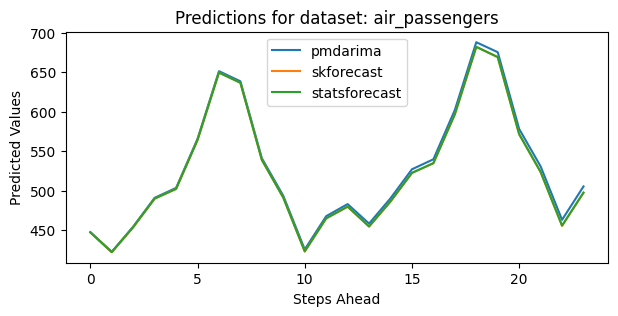

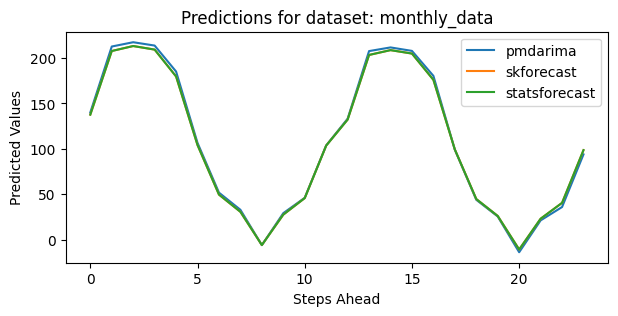

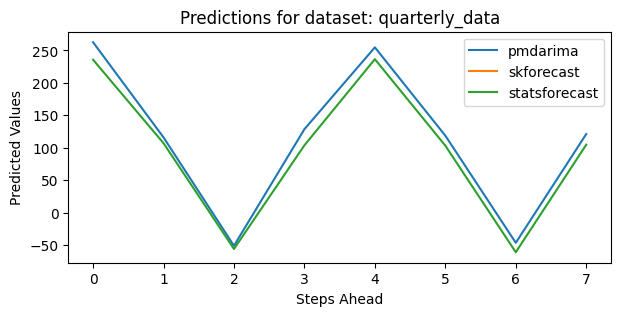

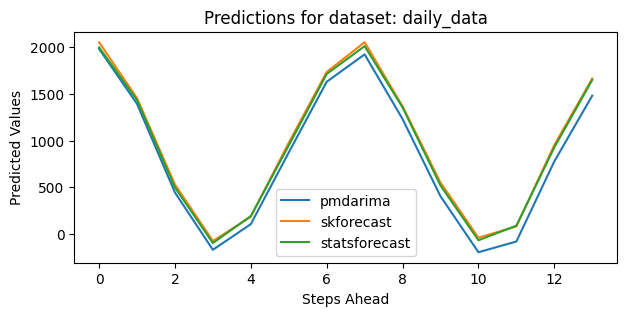

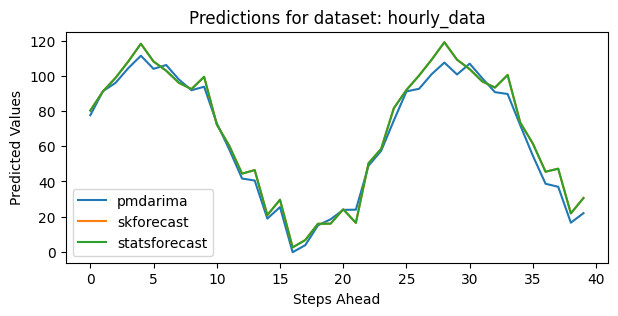

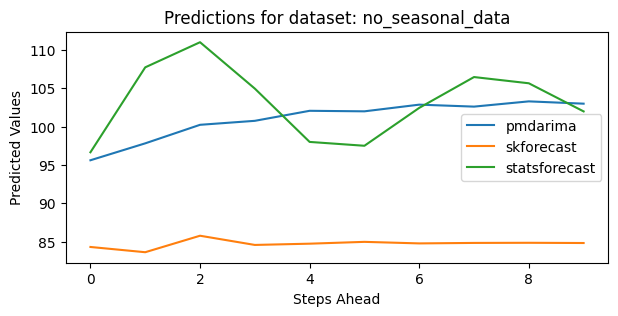

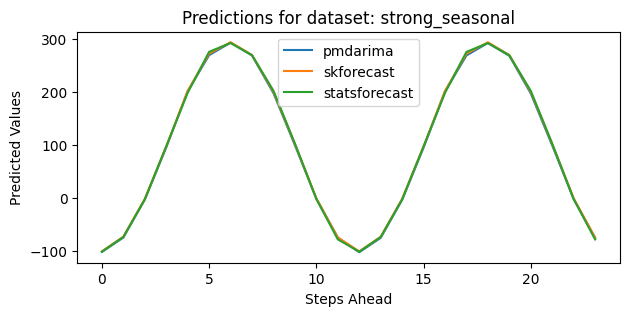

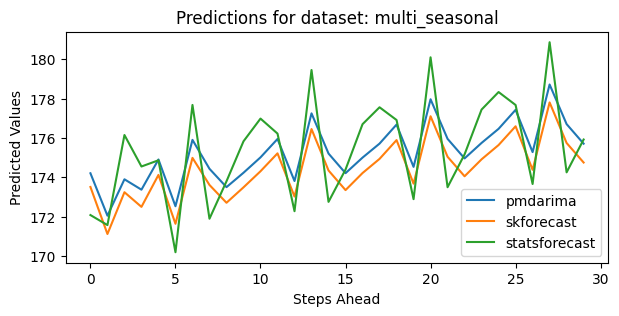

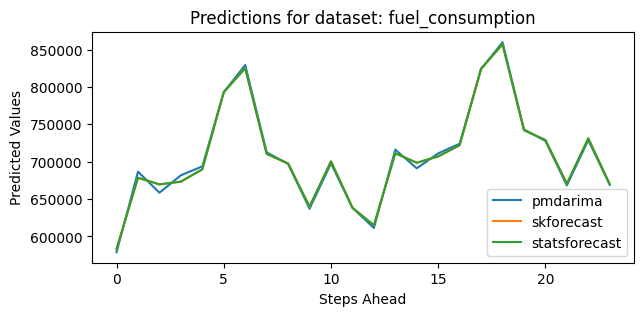

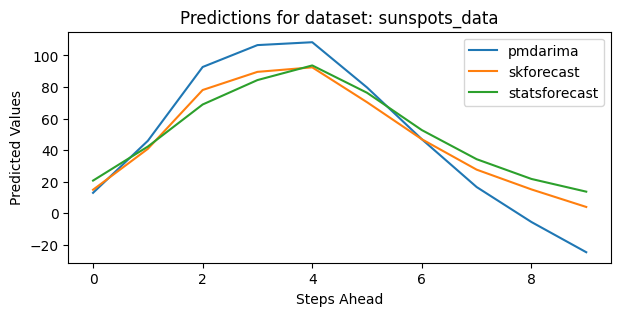

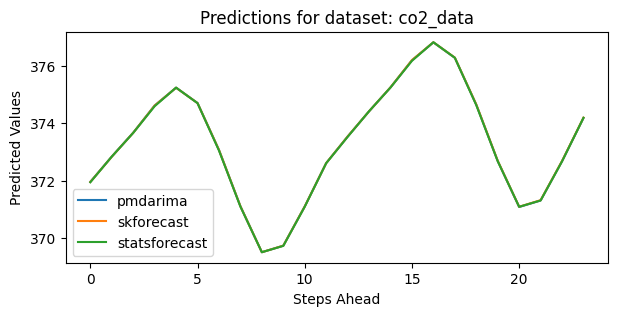

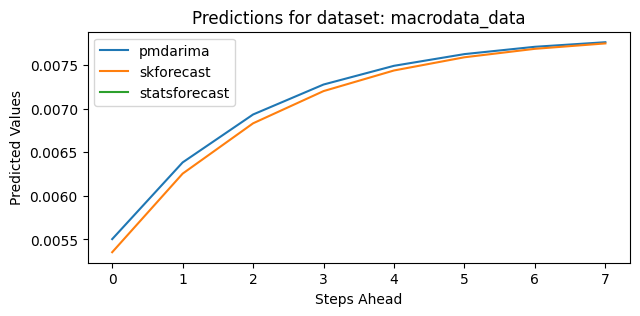

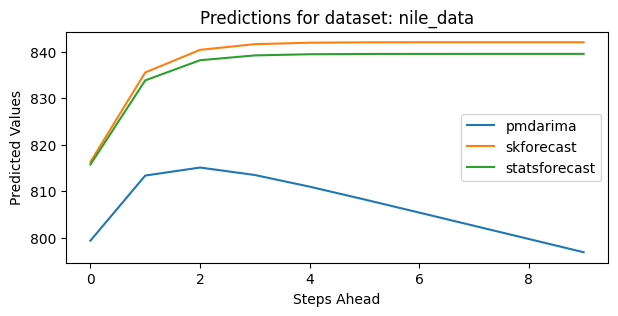

In [84]:
# Plot predictions
# ==============================================================================
import matplotlib.pyplot as plt

for dataset in results_df.index.unique():
    plt.figure(figsize=(7, 3))
    plt.title(f"Predictions for dataset: {dataset}")
    for _, row in results_df.loc[dataset].iterrows():
        plt.plot(
            range(len(row['predictions'])),
            row['predictions'],
            label=row['library']
        )
    plt.xlabel("Steps Ahead")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

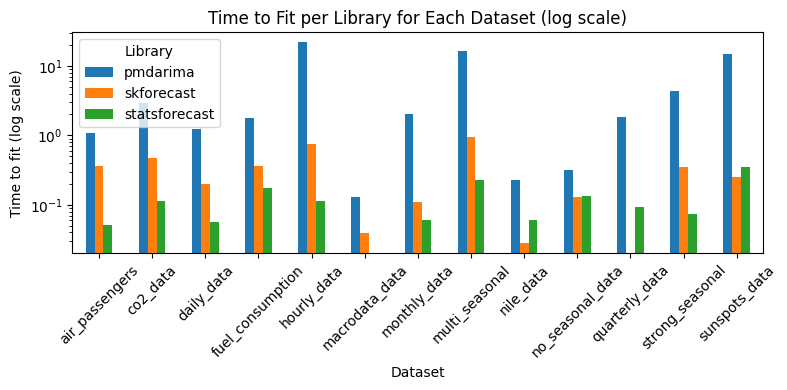

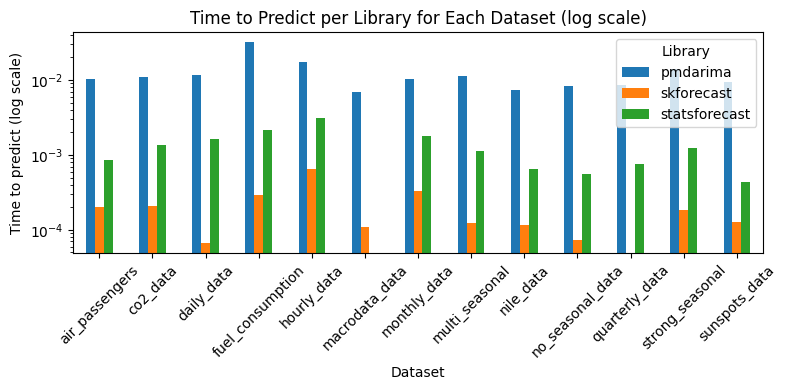

In [92]:
# Plot fitting times
# ==============================================================================
df_plot = results_df.pivot(columns="library", values="time_fit")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to fit (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to Fit per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()

# Plot prediction times
# ==============================================================================
df_plot = results_df.pivot(columns="library", values="time_pred")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to predict (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to Predict per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()